In [54]:
import fitsio
from matplotlib import pyplot as plt
import numpy as np

In [2]:
f = fitsio.read('/global/cfs/cdirs/desi/users/raichoor/desi-fa/dr9-0.53.0-sv2-160ra200_45dec60-4112packing-dark7pass-2021-03-18/outputs/science-after-pass6_162ra198_47dec58.fits')

In [3]:
f.dtype.names

('TARGETID',
 'RA',
 'DEC',
 'RA_IVAR',
 'DEC_IVAR',
 'PMRA',
 'PMDEC',
 'PMRA_IVAR',
 'PMDEC_IVAR',
 'SV2_DESI_TARGET',
 'SV2_BGS_TARGET',
 'SV2_MWS_TARGET',
 'SUBPRIORITY',
 'BRICKNAME',
 'BRICKID',
 'BRICK_OBJID',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'FLUX_G',
 'MW_TRANSMISSION_G',
 'FLUX_R',
 'MW_TRANSMISSION_R',
 'FLUX_Z',
 'MW_TRANSMISSION_Z',
 'FLUX_W1',
 'MW_TRANSMISSION_W1',
 'FLUX_W2',
 'MW_TRANSMISSION_W2',
 'MASKBITS',
 'REF_CAT',
 'MORPHTYPE',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'passbit',
 'islya',
 'ar_nfiber_avail',
 'ar_ntile_avail',
 'ar_numobs_done',
 'SV2_SCND_TARGET',
 'NUMOBS_MORE',
 'NUMOBS',
 'Z',
 'ZWARN',
 'TARGET_STATE',
 'TIMESTAMP',
 'VERSION',
 'PRIORITY',
 'OBSCONDITIONS',
 'ZTILEID')

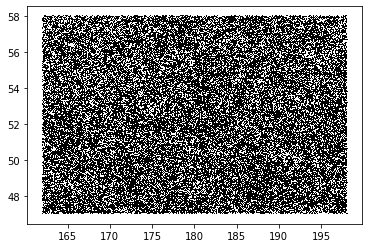

In [18]:
plt.plot(f[wqt]['RA'],f[wqt]['DEC'],',k')

In [6]:
len(f)

934543

In [7]:
f['ar_numobs_done']

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=int16)

In [8]:
td = f["ar_numobs_done"].sum(axis=1)

In [9]:
td

array([1, 1, 1, ..., 0, 0, 1])

In [10]:
sum(td)

643610

In [65]:
#this now selects everything that got assigned
w = td > 0

## just going to split based on priority, since we have a no fiberassign reference

In [13]:
#ELGs
we = f['PRIORITY'] == 3000
wet = we & w

In [17]:
#QSOs
wq = f['PRIORITY'] == 3400
wqt = wq & w

In [36]:
#LRGs
wl = f['PRIORITY'] == 3200
wlt = wl & w

In [37]:
len(f[wlt])/len(f[wl]) #fraction of objects with LRG priority assigned

0.9385744377250799

In [22]:
len(f[wet])/len(f[we]) #fraction with ELG priority assigned

0.6181990673405253

In [66]:
len(f[wqt])/len(f[wq]) #fraction with QSO priority assigned

0.9981952354215128

In [67]:
#function to count pairs within some maximum radius
#angular distance just approximated as d^2 = (Delta dec)^2 + (cos(dec)*Delta ra)^2
def getnp(ra1,dec1,ra2,dec2,cd1,maxa):
    maxa2 = maxa*maxa
    npn = 0
    for i in range(0,len(cd1)):
        rai = ra1[i]
        deci = dec1[i]
        cdi = cd1[i]
        ddi = abs(dec2 - deci)
        wi = ddi < maxa
        dri = abs(ra2-rai)*cdi
        wi &= dri < maxa
        ddiw = ddi[wi]
        driw = dri[wi]
        ws = (ddiw**2.+driw**2.) < maxa2
        npn += len(ddiw[ws])
        if i%10000 == 0:
            print(i,npn)
    return npn        

In [55]:
cd = np.cos(f['DEC']*np.pi/180.)

In [39]:
#cos(dec) before fiberassign
cde = cd[we]
cdq = cd[wq]
cdl = cd[wl]
#cos(dec) after fiberassign
cdet = cd[wet]
cdqt = cd[wqt]
cdlt = cd[wlt]

In [64]:
#split ra/dec by type before fiberassign
raq = f['RA'][wq]
decq = f['DEC'][wq]
rae = f['RA'][we]
dece = f['DEC'][we]
ral = f['RA'][wl]
decl = f['DEC'][wl]
#after fiberassign
raqt = f['RA'][wqt]
decqt = f['DEC'][wqt]
raet = f['RA'][wet]
decet = f['DEC'][wet]
ralt = f['RA'][wlt]
declt = f['DEC'][wlt]

In [ ]:
#no fiberassign, ELGxQSO
maxa = 0.01
npn = getnp(raq,decq,rae,dece,cdq,maxa)

0 0
10000 23991
20000 48939
30000 67601
40000 89419
50000 112754
60000 138345


In [70]:
#fiberassign ELGxQSO
npt = getnp(raqt,decqt,raet,decet,cdqt,maxa)

0 0
10000 12763
20000 26371
30000 36290
40000 48622
50000 62223
60000 76083
70000 90279


In [72]:
#compare fraction of pairs to the fraction expected if reduction in assigned number was random
print(npt/npn,len(raet)/len(rae)*len(raqt)/len(raq),npt/npn/(len(raet)/len(rae)*len(raqt)/len(raq)))

0.5527603115420634 0.6170833635613353 0.8957627837379244


## so we only lose 10% more ELGxQSO pairs than expected if the ELGs were choosen at random

In [74]:
#no fiberassign, ELGxLRG
maxa = 0.01
npl = getnp(ral,decl,rae,dece,cdl,maxa)

0 0
10000 21731
20000 47290
30000 75851
40000 96130
50000 119184
60000 143080
70000 171017
80000 195061
90000 221272
100000 251134
110000 273141
120000 303879
130000 332668
140000 346969


In [76]:
#fiberassign, ELGxLRG
maxa = 0.01
nplt = getnp(ralt,declt,raet,decet,cdlt,maxa)

0 0
10000 12445
20000 24463
30000 40499
40000 52651
50000 61669
60000 82020
70000 92441
80000 109003
90000 126128
100000 139680
110000 154772
120000 175934
130000 182256


In [77]:
#compare fraction of pairs to the fraction expected if reduction in assigned number was random
print(nplt/npl,len(raet)/len(rae)*len(ralt)/len(ral),nplt/npl/(len(raet)/len(rae)*len(ralt)/len(ral)))

0.5306057255873644 0.5802258420313023 0.9144813745795538


## and we lose less than 9% of ELGxLRG pairs

### (below here are just cells where I tested different things out)

In [57]:
#no fiberassign, ELGxQSO
npn = 0
for i in range(0,len(cdq)):
    rai = raq[i]
    deci = decq[i]
    cdi = cdq[i]
    ddi = abs(dece - deci)
    wi = ddi < maxa
    dri = abs(rae-rai)*cdi
    wi &= dri < maxa
    ddiw = ddi[wi]
    driw = dri[wi]
    ws = (ddiw**2.+driw**2.) < maxa2
    npn += len(ddiw[ws])
    if i%1000 == 0:
        print(i,npn)

0 0
1000 941
2000 4148
3000 5890
4000 7801
5000 11872
6000 13985
7000 16989
8000 18356
9000 21644
10000 23991
11000 28022
12000 30798
13000 33355
14000 35679
15000 38540
16000 40198
17000 42486
18000 43780
19000 46608
20000 48939
21000 51682
22000 54686
23000 57010
24000 57975
25000 59043
26000 60108
27000 61127
28000 62096
29000 64985
30000 67601
31000 69233
32000 72559
33000 74945
34000 77614
35000 81339
36000 82098
37000 82832
38000 84519
39000 86317
40000 89419
41000 91356
42000 93360
43000 94502
44000 97415
45000 99898
46000 102971
47000 104978
48000 109297
49000 110968
50000 112754
51000 115566
52000 117125
53000 119123
54000 122271
55000 125491
56000 126625
57000 128467
58000 130777
59000 135299
60000 138345
61000 141345
62000 146786
63000 150692
64000 155886
65000 156979
66000 157986
67000 159064
68000 160110
69000 161442
70000 162995
71000 163946
72000 166908
73000 170256
74000 171323


In [58]:
#fiberassign ELGxQSO
npt = 0
for i in range(0,len(cdqt)):
    rai = raqt[i]
    deci = decqt[i]
    cdi = cdqt[i]
    ddi = abs(decet - deci)
    wi = ddi < maxa
    dri = abs(raet-rai)*cdi
    wi &= dri < maxa
    ddiw = ddi[wi]
    driw = dri[wi]
    ws = (ddiw**2.+driw**2.) < maxa2
    npt += len(ddiw[ws])
    if i%1000 == 0:
        print(i,npt)

0 0
1000 461
2000 2226
3000 3348
4000 4354
5000 6449
6000 7678
7000 9159
8000 9836
9000 11602
10000 12763
11000 15001
12000 16396
13000 17831
14000 19006
15000 20661
16000 21582
17000 22973
18000 23616
19000 25206
20000 26371
21000 28118
22000 29281
23000 30477
24000 30983
25000 31493
26000 32132
27000 32608
28000 33225
29000 34739
30000 36290
31000 37140
32000 39176
33000 40563
34000 41976
35000 44102
36000 44477
37000 44819
38000 45687
39000 46745
40000 48622
41000 49666
42000 50971
43000 51540
44000 53236
45000 55007
46000 56619
47000 57770
48000 60326
49000 61316
50000 62223
51000 63724
52000 64523
53000 65601
54000 67301
55000 69001
56000 69746
57000 70569
58000 72407
59000 74340
60000 76083
61000 78430
62000 81513
63000 83644
64000 86698
65000 87304
66000 87732
67000 88334
68000 88853
69000 89484
70000 90279
71000 90811
72000 92463
73000 94442
74000 94841


In [61]:
npt/npn

0.5527603115420634

In [59]:
#no fiberassign ELGxLRG
npl = 0
for i in range(0,len(cdl)):
    rai = ral[i]
    deci = decl[i]
    cdi = cdl[i]
    ddi = abs(dece - deci)
    wi = ddi < maxa
    dri = abs(rae-rai)*cdi
    wi &= dri < maxa
    ddiw = ddi[wi]
    driw = dri[wi]
    ws = (ddiw**2.+driw**2.) < maxa2
    npl += len(ddiw[ws])
    if i%1000 == 0:
        print(i,npl)

0 0
1000 631
2000 1218
3000 5092
4000 6972
5000 8573
6000 10542
7000 13269
8000 15790
9000 18700
10000 21731
11000 26799
12000 27898
13000 29678
14000 32681
15000 34498
16000 37383
17000 39466
18000 41270
19000 44240
20000 47290
21000 49335
22000 52003
23000 56686
24000 57859
25000 63120
26000 65049
27000 68450
28000 70061
29000 72087
30000 75851
31000 78299
32000 80113
33000 81165
34000 83257
35000 84659
36000 85409
37000 87084
38000 89837
39000 92276
40000 96130
41000 97844
42000 100314
43000 104920
44000 107443
45000 111471
46000 114855
47000 115902
48000 116840
49000 118158
50000 119184
51000 120245
52000 121443
53000 122406
54000 123375
55000 124366
56000 126045
57000 130627
58000 134711
59000 140615
60000 143080
61000 147820
62000 152863
63000 155246
64000 158889
65000 161688
66000 163416
67000 166757
68000 169239
69000 170103
70000 171017
71000 171675
72000 172610
73000 177410
74000 178135
75000 180329
76000 182966
77000 187650
78000 189156
79000 193656
80000 195061
81000 197371

In [60]:
#fibersassign ELGxLRG
nplt = 0
for i in range(0,len(cdlt)):
    rai = ralt[i]
    deci = declt[i]
    cdi = cdlt[i]
    ddi = abs(decet - deci)
    wi = ddi < maxa
    dri = abs(raet-rai)*cdi
    wi &= dri < maxa
    ddiw = ddi[wi]
    driw = dri[wi]
    ws = (ddiw**2.+driw**2.) < maxa2
    nplt += len(ddiw[ws])
    if i%1000 == 0:
        print(i,nplt)

0 0
1000 228
2000 1258
3000 2612
4000 3377
5000 4432
6000 6150
7000 8004
8000 9200
9000 9754
10000 12445
11000 14014
12000 14940
13000 16546
14000 17287
15000 18778
16000 19763
17000 21387
18000 22333
19000 23588
20000 24463
21000 26979
22000 28430
23000 30363
24000 32078
25000 33068
26000 34334
27000 35696
28000 37997
29000 39404
30000 40499
31000 41066
32000 42103
33000 42999
34000 43316
35000 45111
36000 46762
37000 47216
38000 49505
39000 50694
40000 52651
41000 53744
42000 56003
43000 57676
44000 58169
45000 58811
46000 59329
47000 59855
48000 60530
49000 61032
50000 61669
51000 62153
52000 62567
53000 65681
54000 66524
55000 70645
56000 72859
57000 75403
58000 78251
59000 79893
60000 82020
61000 83862
62000 84749
63000 86394
64000 87727
65000 88108
66000 88574
67000 88917
68000 89359
69000 92117
70000 92441
71000 94986
72000 96863
73000 98391
74000 100124
75000 101950
76000 103396
77000 104393
78000 105325
79000 107918
80000 109003
81000 110943
82000 112468
83000 115190
84000 116

In [62]:
nplt/npl


0.5306057255873644